In [13]:
!pip install opendatasets

In [14]:
import opendatasets as od
od.download('https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia')

Skipping, found downloaded files in "./chest-xray-pneumonia" (use force=True to force download)


# Import Library

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import numpy as np
import pandas as pd
from PIL import Image

# Config

In [16]:
n_epochs = 20
learning_rate = 5e-5
patience = 3
weight_decay = 1e-4
batch_size = 64
data_dir = "/kaggle/working/chest-xray-pneumonia/chest_xray"
# data_dir = "/content/chest-xray-pneumonia/chest_xray"
train_dir = data_dir + "/train/"
val_dir = data_dir + "/val/"
test_dir = data_dir + "/test/"

# Dataset

## Class Chest X-ray Dataset

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class ChestXrayDataset(Dataset):
    def __init__(self, data_dir, transform=None, labels=["NORMAL", "PNEUMONIA"]):
        self.data_dir = data_dir
        self.transform = transform
        self.labels = labels
        self.image_paths = []
        self.image_labels = []
        for i, label in enumerate(labels):
            label_dir = os.path.join(data_dir, label)
            image_files = os.listdir(label_dir)
            for image_file in image_files:
                image_path = os.path.join(label_dir, image_file)
                self.image_paths.append(image_path)
                self.image_labels.append(i)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image_label = self.image_labels[index]
        image = Image.open(image_path)
        if image.mode != "RGB":
            image = image.convert("RGB")
        if self.transform:
            image = self.transform(image)

        image_label = torch.nn.functional.one_hot(torch.tensor(image_label), num_classes=len(self.labels))
        return image, image_label

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

## Dataloader

In [18]:
dataset_train = ChestXrayDataset(data_dir=train_dir, transform=transform)
dataset_test = ChestXrayDataset(data_dir=test_dir, transform=transform)
dataset_valid = ChestXrayDataset(data_dir=val_dir, transform=transform)

In [19]:
import torch
from torch.utils.data import random_split, Subset

torch.manual_seed(42)

initial_valid_size = len(dataset_valid)

additional_valid_size = int(len(dataset_train) * 0.15)

train_size = len(dataset_train) - additional_valid_size

train_dataset, additional_valid_dataset = random_split(dataset_train, [train_size, additional_valid_size])

valid_dataset = torch.utils.data.ConcatDataset([dataset_valid, additional_valid_dataset])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=False)

In [20]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([64, 3, 224, 224]) torch.Size([64, 2])


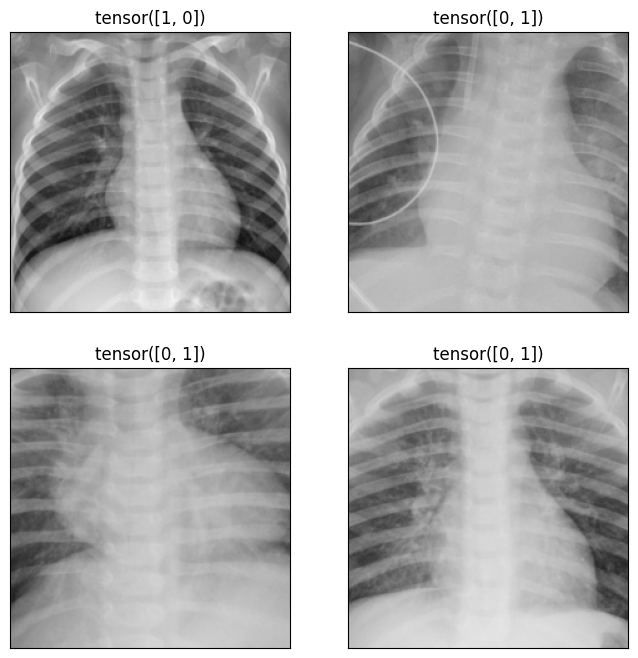

In [21]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))

def tensor_to_image(tensor):
    tensor = tensor.clone().detach()
    if tensor.device == "cuda":
        tensor = tensor.cpu()
    array = tensor.numpy()
    array = array.transpose((1, 2, 0))
    array = array * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)
    array = array.clip(0, 1)
    return array

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    image = tensor_to_image(images[i])
    label = labels[i]
    ax.imshow(image)
    ax.set_title(label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

## EarlyStopping

In [22]:
class EarlyStopping:
    def __init__(self, patience=3, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

## Evalution

In [23]:
import torch
import numpy as np

def get_acc(predictions, targets):
    predictions = predictions.detach().cpu()
    targets = targets.detach().cpu()

    predictions_np = predictions.numpy()
    targets_np = targets.numpy()

    predicted_labels = np.argmax(predictions_np, axis=1)
    target_labels = np.argmax(targets_np, axis=1)

    correct_predictions = np.equal(predicted_labels, target_labels)

    accuracy = np.mean(correct_predictions.astype(float))
    return accuracy

# Model

In [24]:
class VGG19Classifier(nn.Module):
    def __init__(self, num_classes = 2):
        super(VGG19Classifier, self).__init__()

        self.vgg19 = torchvision.models.vgg19_bn(pretrained=True)
        
        for param in self.vgg19.features.parameters():
            param.requires_grad = False
            
        in_features = self.vgg19.classifier[0].in_features
        new_classifier = nn.Sequential(
            nn.Flatten(start_dim=1, end_dim=-1),
            nn.Linear(in_features = in_features, out_features = 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, num_classes),
        )
        self.vgg19.classifier = new_classifier


    def forward(self, x):
        return self.vgg19(x)

# Training

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGG19Classifier().to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

early_stopping = EarlyStopping(patience = patience, verbose=True)

scheduler = StepLR(optimizer, step_size = 4, gamma = 0.1)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:01<00:00, 289MB/s]  


In [26]:
list_loss = []
list_acc = []
list_dev_loss = []
list_dev_acc = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    epoch_acc = 0.0

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    model.train()
    for i, (images, labels) in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(images)

        loss = criterion(output, labels.float())

        acc = get_acc(output, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc
        pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss / (i+1):.4f}, Accuracy: {epoch_acc / (i+1):.4f}')

    # Step the learning rate scheduler
    scheduler.step()

    epoch_loss /= len(train_loader)
    epoch_acc /= len(train_loader)
    list_loss.append(epoch_loss)
    list_acc.append(epoch_acc)

    dev_loss = 0.0
    dev_acc = 0.0

    model.eval()
    with torch.no_grad():
        for images, labels in valid_loader:
            labels = labels.to(float)
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            acc = get_acc(outputs, labels)

            dev_loss += loss.item()
            dev_acc += acc

    dev_loss /= len(valid_loader)
    dev_acc /= len(valid_loader)

    list_dev_loss.append(dev_loss)
    list_dev_acc.append(dev_acc)
    print(f"Epoch {epoch+1}/{n_epochs} | Training Loss: {epoch_loss:.6f} | Val Loss: {dev_loss:.6f} | Val Accuracy: {dev_acc:.4f}")

    early_stopping(dev_loss, model)
    if early_stopping.early_stop:
        n_epochs = epoch + 1
        print("Early stopping")
        break

Epoch [1/20], Loss: 0.1876, Accuracy: 0.9310: 100%|██████████| 70/70 [01:28<00:00,  1.26s/it]


Epoch 1/20 | Training Loss: 0.187635 | Val Loss: 0.092487 | Val Accuracy: 0.9674
Validation loss decreased (inf --> 0.092487).  Saving model ...


Epoch [2/20], Loss: 0.0696, Accuracy: 0.9768: 100%|██████████| 70/70 [01:26<00:00,  1.24s/it]


Epoch 2/20 | Training Loss: 0.069615 | Val Loss: 0.073041 | Val Accuracy: 0.9784
Validation loss decreased (0.092487 --> 0.073041).  Saving model ...


Epoch [3/20], Loss: 0.0426, Accuracy: 0.9873: 100%|██████████| 70/70 [01:26<00:00,  1.24s/it]


Epoch 3/20 | Training Loss: 0.042580 | Val Loss: 0.066391 | Val Accuracy: 0.9784
Validation loss decreased (0.073041 --> 0.066391).  Saving model ...


Epoch [4/20], Loss: 0.0255, Accuracy: 0.9955: 100%|██████████| 70/70 [01:26<00:00,  1.24s/it]


Epoch 4/20 | Training Loss: 0.025529 | Val Loss: 0.063979 | Val Accuracy: 0.9784
Validation loss decreased (0.066391 --> 0.063979).  Saving model ...


Epoch [5/20], Loss: 0.0192, Accuracy: 0.9973: 100%|██████████| 70/70 [01:27<00:00,  1.24s/it]


Epoch 5/20 | Training Loss: 0.019179 | Val Loss: 0.064462 | Val Accuracy: 0.9808


Epoch [6/20], Loss: 0.0196, Accuracy: 0.9963: 100%|██████████| 70/70 [01:26<00:00,  1.23s/it]


Epoch 6/20 | Training Loss: 0.019619 | Val Loss: 0.063753 | Val Accuracy: 0.9796
Validation loss decreased (0.063979 --> 0.063753).  Saving model ...


Epoch [7/20], Loss: 0.0175, Accuracy: 0.9973: 100%|██████████| 70/70 [01:27<00:00,  1.24s/it]


Epoch 7/20 | Training Loss: 0.017491 | Val Loss: 0.064228 | Val Accuracy: 0.9784


Epoch [8/20], Loss: 0.0159, Accuracy: 0.9989: 100%|██████████| 70/70 [01:26<00:00,  1.24s/it]


Epoch 8/20 | Training Loss: 0.015938 | Val Loss: 0.063997 | Val Accuracy: 0.9784


Epoch [9/20], Loss: 0.0156, Accuracy: 0.9989: 100%|██████████| 70/70 [01:27<00:00,  1.25s/it]


Epoch 9/20 | Training Loss: 0.015566 | Val Loss: 0.064177 | Val Accuracy: 0.9784
Early stopping


# Test Model

In [27]:
model.eval()
y_true_all = []
y_pred_all = []
test_acc = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.to(float)
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        acc = get_acc(outputs, labels)
        test_acc += acc

        y_true_all.extend(torch.argmax(labels.cpu(), dim=1).numpy())
        y_pred_all.extend(torch.argmax(outputs.cpu(), dim=1).numpy())

test_acc /= len(test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.7885


In [28]:
labels = ["NORMAL", "PNEUMONIA"]
print(classification_report(y_true_all, y_pred_all, target_names = labels, digits=4, zero_division=0))

              precision    recall  f1-score   support

      NORMAL     0.9722    0.4487    0.6140       234
   PNEUMONIA     0.7500    0.9923    0.8543       390

    accuracy                         0.7885       624
   macro avg     0.8611    0.7205    0.7342       624
weighted avg     0.8333    0.7885    0.7642       624



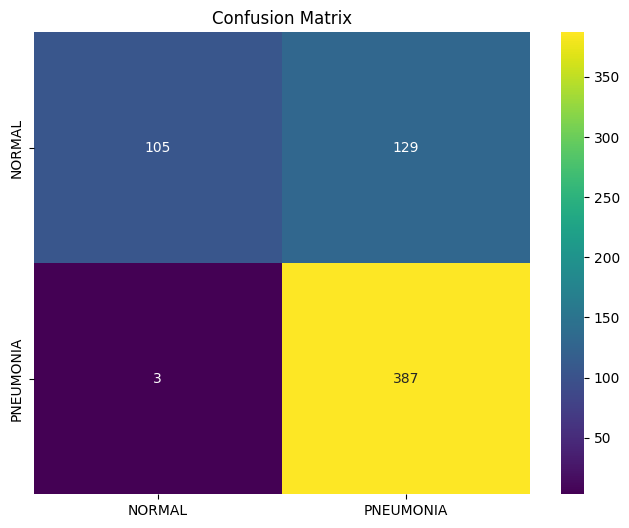

In [29]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True,  cmap='viridis', fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.show()

## Plot

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

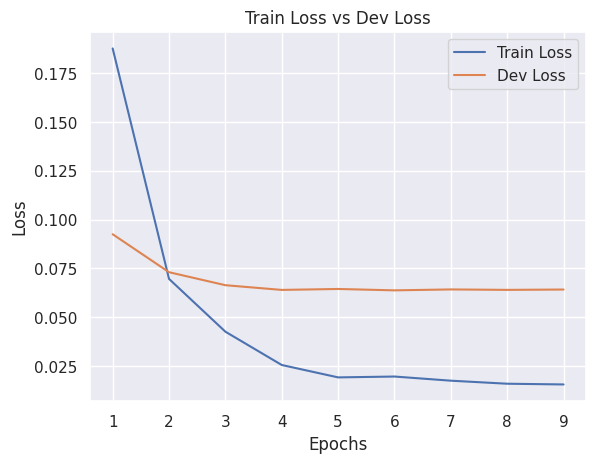

In [30]:
data = {
    "Epochs": list(range(1, n_epochs + 1)),
    "Train Loss": list_loss,
    "Train Acc": list_acc,
    "Dev Loss": list_dev_loss,
    "Dev Acc": list_dev_acc
}
df = pd.DataFrame(data)

sns.set(style="darkgrid")
sns.lineplot(data=df, x="Epochs", y="Train Loss", label="Train Loss")
sns.lineplot(data=df, x="Epochs", y="Dev Loss", label="Dev Loss")
plt.title('Train Loss vs Dev Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

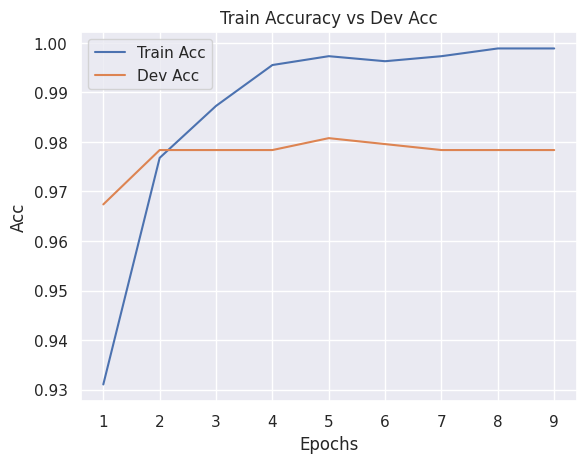

In [31]:
sns.lineplot(data=df, x="Epochs", y="Train Acc", label="Train Acc")
sns.lineplot(data=df, x="Epochs", y="Dev Acc", label="Dev Acc")
plt.title('Train Accuracy vs Dev Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()